# Больше практики.

### Validation curves and learning curves.

In [1]:
from __future__ import division, print_function
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

### Попытаемся ответить на вопрос, что делать, если качество модели нас не устраивает?

Есть несколько путей решения:

a) добавить признаков

б) добавить данных

в) усложнить/упростить модель

Изначально не очевидно, какой (или какие) подходы позволят улучшить качество модели.

Посмотрим на пример. Будем работать с данными по оттоку клиентов телеком-оператора.

In [2]:
data = pd.read_csv('telecom_churn.csv').drop('State', axis=1)
data.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Преобразуйте колонку International plan таким образом, чтобы вместо Yes в ней стояла 1, а вместо No - 0.

Аналогичным образом преобразуйте колонку Voice mail plan.

Затем преобразуйте значения колонки Churn (целевой столбец) в 1 (если True) и 0 (если False).

In [3]:
#your code here

data['International plan'] = data['International plan'].map({'Yes': 1, 'No': 0})
#data['International plan'] = data['International plan'].apply(lambda x: 1 if x == 'Yes' else 0)
data['Voice mail plan'] = data['Voice mail plan'].map({'Yes': 1, 'No': 0})
data['Churn'] = data['Churn'].astype(int)

In [4]:
data.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [5]:
y = data['Churn']
X = data.drop('Churn', axis=1).values

Перед применением линейной модели **необходимо масштабировать признаки**. Создадим пайплайн, в котором сначала происходит масштабирование, а затем применяется модель. В данном случае будем использовать логистическую регрессию.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logit_pipe = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression())])

Обучите модель (logit_pipe) по кросс-валидации и выведите на экран roc-auc (используйте функцию cross_val_score).

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

#your code here
print(cross_val_score(logit_pipe, X, y, cv=3, scoring='roc_auc').mean())

0.8141920017434892


Как правило, подбор гиперпараметров алгоритма улучшает его качество. Подберём значение параметра регуляризации C в логистической регрессии по кросс-валидации, используя GridSearchCV (см. семинар 4).

In [8]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {'logit__C': np.logspace(-2, 0, 20)}

grid_logit = GridSearchCV(logit_pipe, param_grid, cv=3, n_jobs=-1)

grid_logit.fit(X, y)

Wall time: 2.46 s


In [9]:
grid_logit.best_params_, grid_logit.best_score_

({'logit__C': 0.01}, 0.8622862286228623)

Часто бывает полезно построить графики, отображающие качество алгоритма на тренировочной и валидационной выборках в зависимости от значения гиперпараметра. 

Такие графики называются валидационными кривыми.

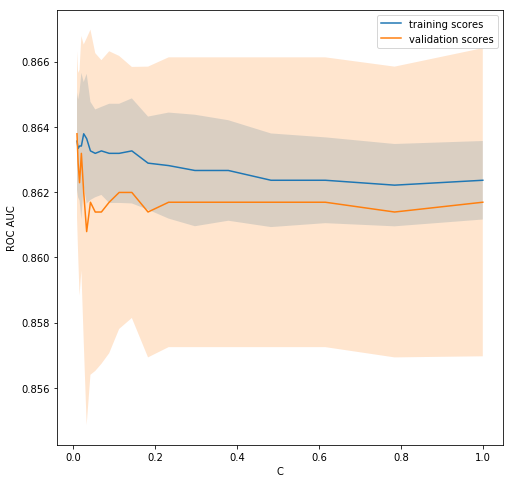

In [10]:
from sklearn.model_selection import validation_curve

alphas = np.logspace(-2, 0, 20)
val_train, val_test = validation_curve(logit_pipe, X, y, "logit__C", alphas, cv=5)

def plot_with_err(x, data, label):
    mu, std = data.mean(axis=1), data.std(axis=1)
    lines = plt.plot(x, mu,label=label)
    plt.fill_between(x, mu - std, mu + std, facecolor=lines[0].get_color(), alpha=0.2)

plt.figure(figsize=(8,8))
plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('ROC AUC')
plt.legend()

Для простых моделей тренировочная и валидационная ошибка находятся где-то рядом, и они велики. Это говорит о том, что модель **недообучилась**: то есть она не имеет достаточное кол-во параметров.

Для сильно усложненных моделей тренировочная и валидационная ошибки значительно отличаются. Это можно объяснить **переобучением**: когда параметров слишком много либо не хватает регуляризации, алгоритм может "отвлекаться" на шум в данных и упускать основной тренд.

Попробуем улучшить модель путём добавления новых признаков.

Тогда происходит три действия: масштабирование, добавление признаков и применение модели. Объедините их в один пайплайн.

In [11]:
#your code here

logit_pipe2 = Pipeline([('scaler', StandardScaler()), ('features', PolynomialFeatures(degree=2)), \
                        ('logit', LogisticRegression())])

Подберите значение параметра C по кросс-валидации

In [12]:
#your code here

param_grid = {'logit__C': np.logspace(-2, 0, 20)}

grid_logit2 = GridSearchCV(logit_pipe2, param_grid, cv=3, n_jobs=-1)

grid_logit2.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('logit', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'logit__C': array([0.01   , 0.01274, 0.01624, 0.02069, 0.02637, 0.0336 , 0.04281,
       0.05456, 0.06952, 0.08859, 0.11288, 0.14384, 0.1833 , 0.23357,
       0.29764, 0.37927, 0.48329, 0.61585, 0.78476, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [13]:
grid_logit2.best_params_, grid_logit2.best_score_

({'logit__C': 1.0}, 0.9096909690969097)

Визуализируйте validation_curve.

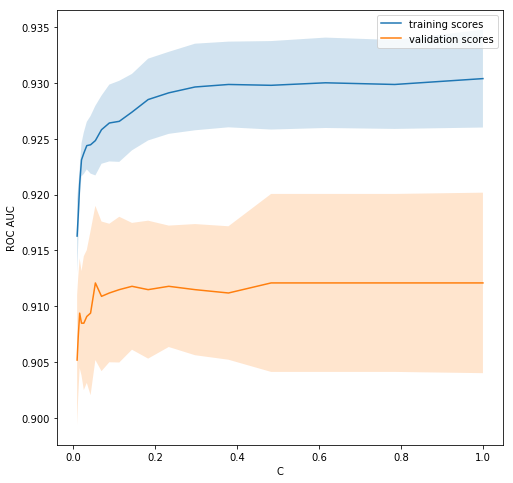

In [14]:
#your code here
val_train, val_test = validation_curve(logit_pipe2, X, y, "logit__C", alphas, cv=5)

plt.figure(figsize=(8,8))
plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('ROC AUC')
plt.legend()

### Сколько нужно данных?

Чем больше данных использует модель, тем лучше. Но как нам понять в конкретной ситуации, помогут ли новые данные? 

Имеет смысл поварьировать размер имеющейся обучающей выборки и посмотреть, как качество решения задачи зависит от объема данных, на котором мы обучали модель. Так получаются кривые обучения (learning curves).

Идея простая: **мы отображаем ошибку как функцию от количества примеров, используемых для обучения. При этом параметры модели фиксируются заранее**.

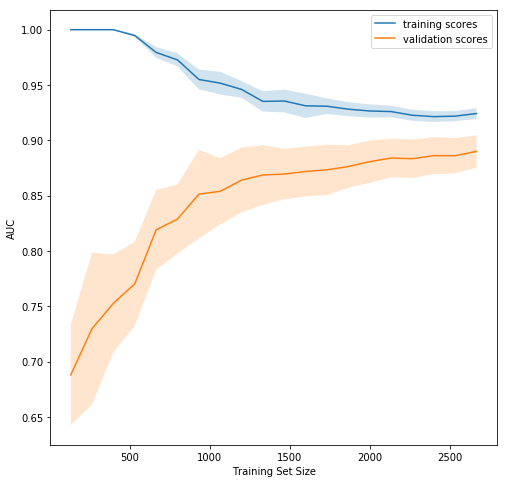

In [15]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(degree=2, C=1.):
    train_sizes = np.linspace(0.05, 1, 20)
    logit_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=degree)), 
                           ('sgd_logit', LogisticRegression(n_jobs=-1, random_state=17, C=C))])

    N, val_train, val_test = learning_curve(logit_pipe,
                                                  X, y, train_sizes=train_sizes, cv=5,
                                                  scoring='roc_auc')
    
    plt.figure(figsize=(8,8))
    plot_with_err(N, val_train, label='training scores')
    plot_with_err(N, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('AUC')
    plt.legend()
    
plot_learning_curve(degree=2, C=5)

Типичная ситуация: для небольшого объема данных ошибки на обучающей выборке и в процессе кросс-валидации довольно сильно отличаются, что указывает на переобучение. Для той же модели, но с большим объемом данных ошибки "сходятся", что указывается на недообучение.

Если добавить еще данные, ошибка на обучающей выборке не будет расти, но с другой стороны, ошибка на тестовых данных не будет уменьшаться.

Получается, ошибки "сошлись", и добавление новых данных не поможет. Собственно, это случай – самый интересный. Возможна ситуация, когда мы увеличиваем выборку в 10 раз. Но если не менять сложность модели, это может и не помочь. То есть стратегия "настроил один раз – дальше использую 10 раз" может и не работать.

Что будет, если изменить коэффициент регуляризации? Видим хорошую тенденцию – кривые постепенно сходятся, и если дальше двигаться направо (добавлять в модель данные), можно еще повысить качество на валидации.

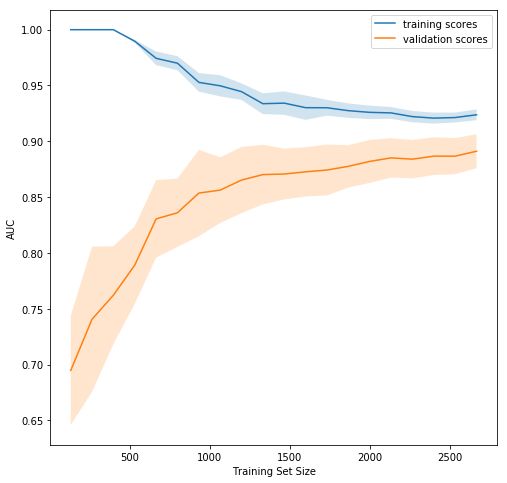

In [16]:
plot_learning_curve(degree=2, C=1.)

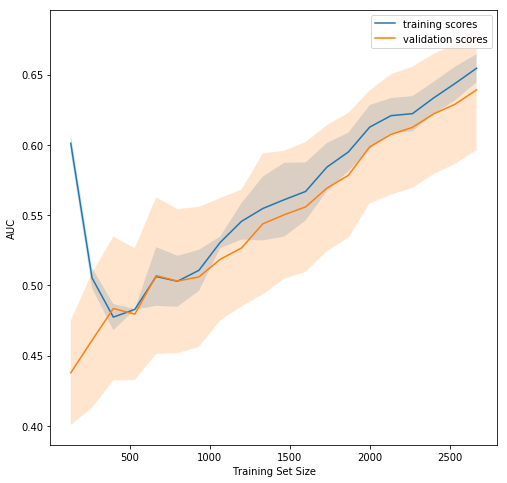

In [17]:
plot_learning_curve(degree=2, C=1e-4)

Видно, что при сильном уменьшении коэффициента регуляризации (= усложнении модели) начинается переобучение.

Строя подобные кривые, можно понять, в какую сторону двигаться, и как правильно настроить сложность модели на новых данных.

# Выводы

1. Ошибка на обучающей выборке сама по себе ничего не говорит о качестве модели

2. Кросс-валидационная ошибка показывает, насколько хорошо модель подстраивается под данные (имеющийся тренд в данных), сохраняя при этом способность обобщения на новые данные

3. **Валидационная кривая** представляют собой график, показывающий результат на тренировочной и валидационной выборке в зависимости от сложности модели:

если две кривые распологаются близко, и обе ошибки велики, - это признак недообучения

если две кривые далеко друг от друга, - это показатель переобучения

4. **Кривая обучения** - это график, показывающий результаты на валидации и тренировочной подвыборке в зависимости от количества наблюдений.

если кривые сошлись друг к другу, добавление новых данных не поможет – надо менять сложность модели

если кривые еще не сошлись, добавление новых данных может улучшить результат.

# Задание.

Примените метод опорных векторов для решения данной задачи. 

Используйте пайплайн, состоящий из масштабирования, извлечения квадратичных признаков и применения SVM.

Вычислите качество алгоритма на кросс-валидации.

In [20]:
from sklearn.svm import SVC

#your code here
svc_pipe3 = Pipeline([('scaler', StandardScaler()), ('features', PolynomialFeatures(degree=2)), \
                      ('svc', SVC())])

print(cross_val_score(svc_pipe3, X, y, cv=3).mean())

param_grid = {'svc__C': np.logspace(-2, 1, 20)}

grid_svc = GridSearchCV(svc_pipe3, param_grid, cv=3, n_jobs=-1)

grid_svc.fit(X, y)

0.9006900690069006


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'svc__C': array([ 0.01   ,  0.01438,  0.02069,  0.02976,  0.04281,  0.06158,
        0.08859,  0.12743,  0.1833 ,  0.26367,  0.37927,  0.54556,
        0.78476,  1.12884,  1.62378,  2.33572,  3.35982,  4.83293,
        6.95193, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
grid_svc.best_params_, grid_svc.best_score_

({'svc__C': 2.3357214690901213}, 0.9108910891089109)

Схема работы с моделью:

1) Подбор параметров и проверка качества по кросс-валидации

2) Обучение на тренировочных данных (fit)

3) Предсказание на новых данных (predict)

Подберите значение параметра регуляризации C по кросс-валидации и нарисуйте валидационную кривую, отражающую качество в зависимости от C. Сделайте выводы.

In [ ]:
#your code here

Как ведет себя алгоритм в зависимости от величины выборки? Нарисуйте learning_curves.

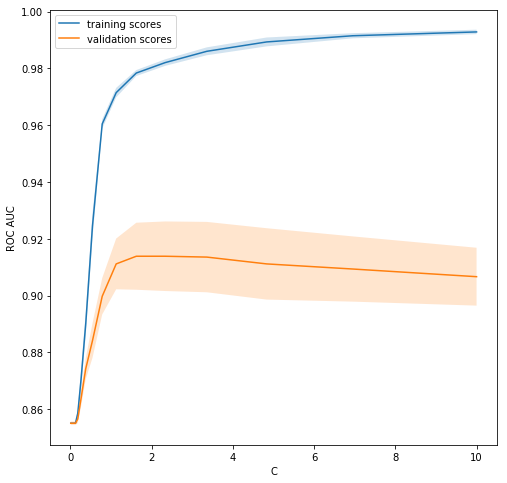

In [21]:
#your code here

alphas = np.logspace(-2, 1, 20)
val_train, val_test = validation_curve(svc_pipe3, X, y, "svc__C", alphas, cv=5)

plt.figure(figsize=(8,8))
plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('ROC AUC')
plt.legend()

In [22]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, degree=2, C=1.):
    train_sizes = np.linspace(0.05, 1, 20)
    logit_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=degree)), 
                           ('model', model)])

    N, val_train, val_test = learning_curve(logit_pipe,
                                                  X, y, train_sizes=train_sizes, cv=5,
                                                  scoring='roc_auc')
    
    plt.figure(figsize=(8,8))
    plot_with_err(N, val_train, label='training scores')
    plot_with_err(N, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('AUC')
    plt.legend()
    
plot_learning_curve(SVC(), degree=2, C=5)

KeyboardInterrupt: 

Посмотрите на количество 0 и 1 в целевой переменной. Является ли выборка сбалансированной?

In [ ]:
#your code here

Добавьте в обученную выше последнюю версию линейной регрессии параметр class_weight = 'balanced'. Посмотрите на качество на кросс-валидации.

In [ ]:
#your code here

Аналогично - добавьте в модель SVM параметр class_weight = 'balanced' и выведите на экран качество алгоритма на кросс-валидации.

In [ ]:
#your code here

Посмотрим, улучшит ли качество применение SVM с ядром. Попробуйте использовать SVM с различными ядрами для данной задачи. 

Для каждого ядра подберите значение параметра C по кросс-валидации.

Для наилучшего из алгоритмов выведите график learning curve.

In [ ]:
#your code here

# Решающие деревья

Рассмотрим модельную задачу регрессии. Объектами будут являться точки на плоскости (т.е. каждый объект описывается 2 признаками), целевая переменная — расстояние от объекта до точки (0, 0).

Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей красивой визуализации

In [2]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

Сгенерируем выборку

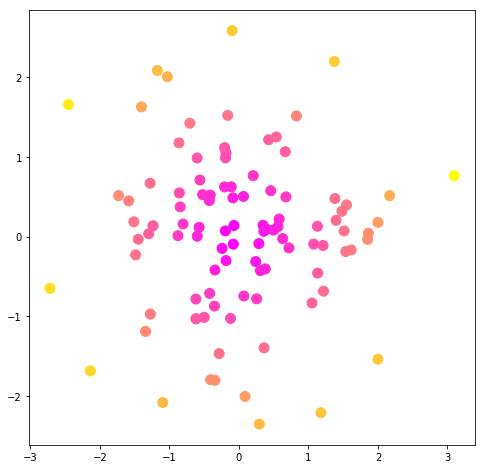

In [3]:
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

Обучим дерево на сгенерированных данных и предскажем ответы для каждой точки решетки

[[-3.71823524 -3.35376476]
 [-3.70823524 -3.35376476]
 [-3.69823524 -3.35376476]
 ...
 [ 4.07176476  3.57623524]
 [ 4.08176476  3.57623524]
 [ 4.09176476  3.57623524]]


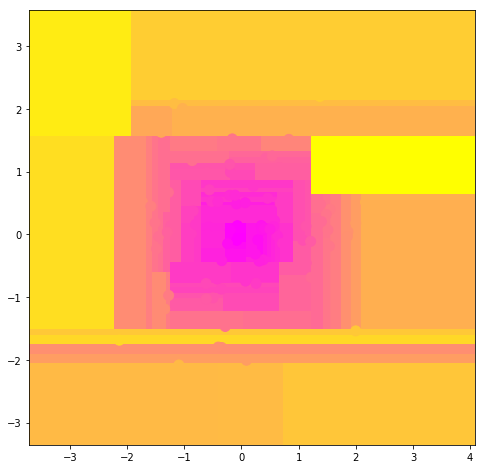

In [4]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor()
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)
print(np.c_[xx.ravel(), yy.ravel()])

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

### Задание

Сейчас мы сгенерировали 100 точек из нормального распределения и обучили решающее дерево на них. Сгенерируйте 300 точек из нормального распределения, обучите на них дерево и выведите на экран результат (как на картинке выше).

Сгенерированные точки и расстояние до точек сохраните в массивы data_x300, data_y300, для обучения и предсказания используйте эти массивы.

Улучшилось ли предсказание алгоритма на решётке? (т.е. стала ли раскраска всей плоскости более правильной?)

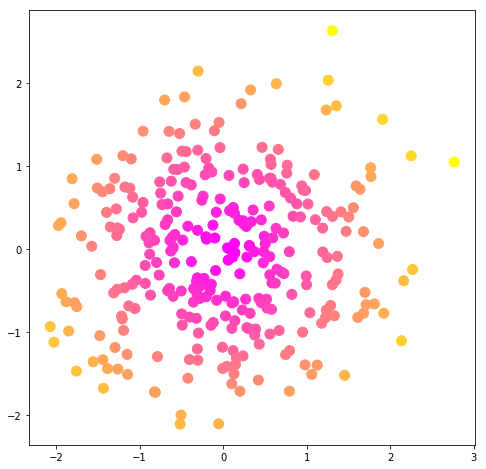

In [7]:
#your code here
data_x300 = np.random.normal(size=(300, 2))
data_y300 = (data_x300[:, 0] ** 2 + data_x300[:, 1] ** 2) ** 0.5
plt.figure(figsize=(8, 8))
plt.scatter(data_x300[:, 0], data_x300[:, 1], c=data_y300, s=100, cmap='spring')

[[-3.06958828 -3.10372017]
 [-3.05958828 -3.10372017]
 [-3.04958828 -3.10372017]
 ...
 [ 3.74041172  3.62627983]
 [ 3.75041172  3.62627983]
 [ 3.76041172  3.62627983]]


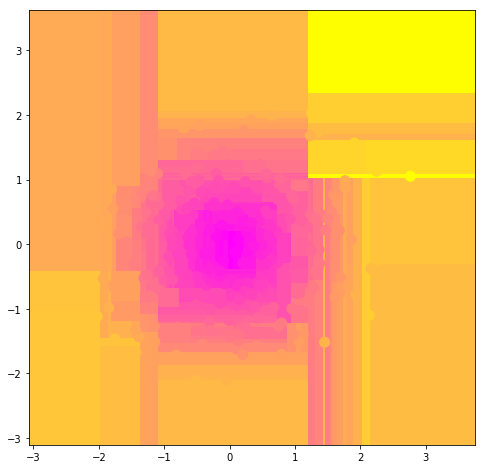

In [8]:
clf = DecisionTreeRegressor()
clf.fit(data_x300, data_y300)

xx, yy = get_grid(data_x300)
print(np.c_[xx.ravel(), yy.ravel()])

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x300[:, 0], data_x300[:, 1], c=data_y300, s=100, cmap='spring')

Вернёмся к исходным данным (100 точек).

Посмотрим как будут выглядеть разделяющая поверхность в зависимости от 
- минимального количества объектов в листе
- максимальной глубины дерева

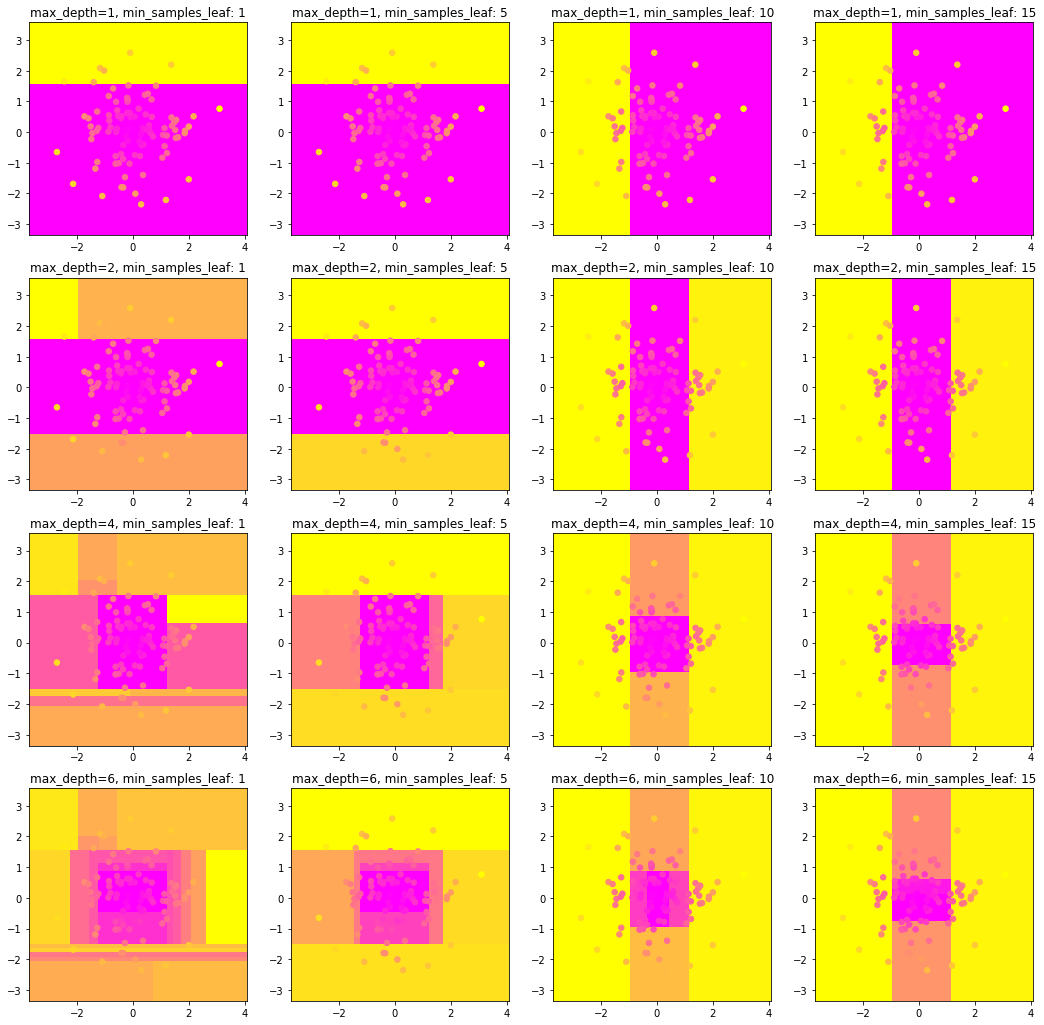

In [9]:
plt.figure(figsize=(18, 18))
for i, max_depth in enumerate([1, 2, 4, 6]):
    for j, min_samples_leaf in enumerate([1, 5, 10, 15]):
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((4, 4), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring')
        plt.title('max_depth=' + str(max_depth) + ', min_samples_leaf: ' + str(min_samples_leaf))

- Как влияет увеличение максимальной глубины и/или уменьшение минимального количества объектов выборки в листе на качество на обучающей выборке? на переобучение?

## Неустойчивость решающих деревьев

Решающие деревья — это алгоритмы, неустойчивые к изменениям обучающей выборки, т.е. при малейших её изменениях итоговый классификатор может радикально измениться.
Посмотрим, как будет меняться структура дерева при обучении на разных 90%-х подвыборках.

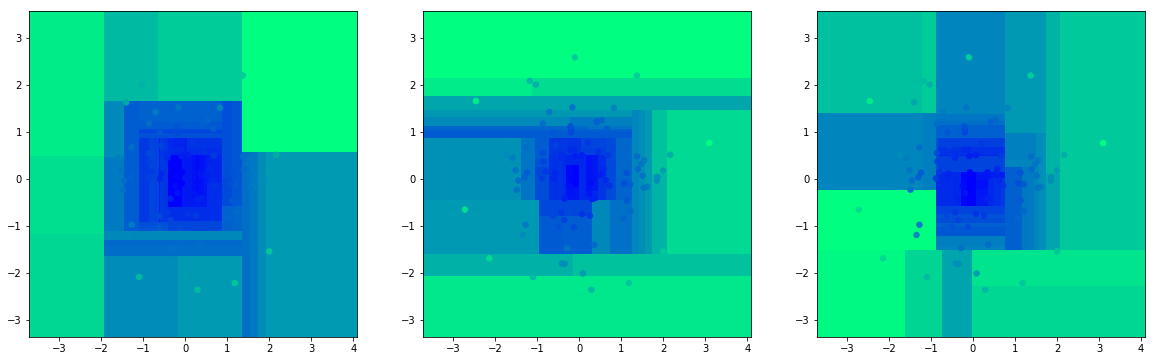

In [10]:
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=42)

    indices = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indices], data_y[indices])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter')

## Подбор параметров

Посмотрим на качество дерева в зависимости от параметров на одном из стандартных наборов данных - Бостонском датасете.

In [11]:
from sklearn.datasets import load_boston

data = load_boston()
print(data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [12]:
X = data.data
y = data.target

X.shape

(506, 13)

### Визуализация решающего дерева

conda install graphviz

conda install -c conda-forge pydotplus

In [21]:
from sklearn.tree import DecisionTreeRegressor

tr = DecisionTreeRegressor(max_depth=3)
tr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

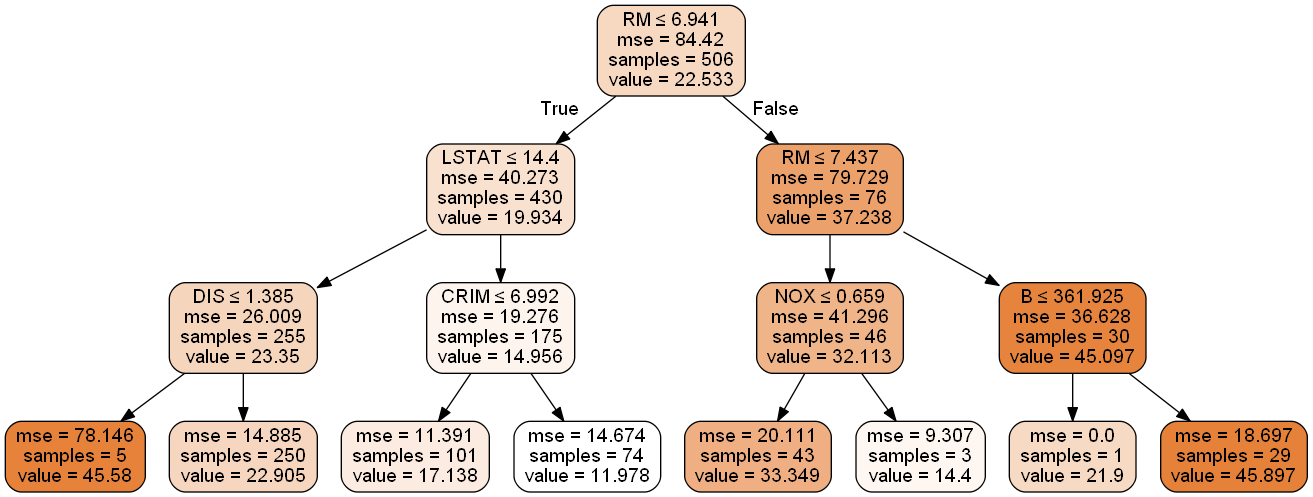

In [22]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(tr, out_file=dot_data, feature_names=data.feature_names,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

- будем оценивать качество алгоритма по кросс-валидации

Можем зафиксировать разбиение на фолды, чтобы затем каждый раз использовать одно и то же разбиение при кросс-валидации, это полезно при сравнении алгоритмов

In [13]:
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(X.shape[0], shuffle=True, random_state=241)

Выведите качество DecisionTreeRegressor, обученного на данных X, y по кросс-валидации. В функции cross_val_score в качестве cv поставьте cv=cv, в качестве метрики - 'neg_mean_squared_error'

In [19]:
#your code here
cross_val_score(tr, X, y, cv=cv, scoring='neg_mean_squared_error').mean()

-18.76393280632411

### Задание

Метрика MSЕ имеет не ограничена сверху. Поэтому для оценки качества алгоритма можно также пользоваться метрикой R2 (коэффициент детерминации), так как он не превышает 1 (и чем ближе к 1, тем лучше).

Выведите на экран значение R2 алгоритма ('r2').

In [20]:
#your code here
cross_val_score(tr, X, y, cv=cv, scoring='r2').mean()

0.03359683794466403

Для сравнения качества модели при различных наборах параметров или для сравнения моделей на одном датасете можно использовать, как и раньше, MSE.

Будем подбирать параметры решающего дерева по сетке с целью увеличить качество алгоритма. Будем подбирать значения max_features и max_depth.

In [15]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

Подберите по кросс-валидации оптимальные значения max_features и max_depth. В функции GridSearchCV в качестве cv поставьте заранее фиксированное разбиение (cv=cv), метрику качества используйте scoring='neq_mean_squared_error'

In [24]:
from sklearn.model_selection import GridSearchCV

params={'max_features': [None, 'log2', 'sqrt'], 
        'max_depth': [2, 4, 6, 8, 10, 20, 50]},

gs = GridSearchCV(DecisionTreeRegressor(), params, scoring='neg_mean_squared_error', \
                  cv=cv, n_jobs=-1)

gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=506, random_state=241, shuffle=True),
       error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=({'max_features': [None, 'log2', 'sqrt'], 'max_depth': [2, 4, 6, 8, 10, 20, 50]},),
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Выведем на экран средние значения и стандартные отклонения, полученные при GridSearch.

In [25]:
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))

-28.783 (+/-163.634) for {'max_depth': 2, 'max_features': None}
-47.078 (+/-244.855) for {'max_depth': 2, 'max_features': 'log2'}
-48.499 (+/-241.414) for {'max_depth': 2, 'max_features': 'sqrt'}
-20.486 (+/-154.012) for {'max_depth': 4, 'max_features': None}
-35.865 (+/-227.010) for {'max_depth': 4, 'max_features': 'log2'}
-32.012 (+/-200.765) for {'max_depth': 4, 'max_features': 'sqrt'}
-17.089 (+/-113.929) for {'max_depth': 6, 'max_features': None}
-27.349 (+/-185.726) for {'max_depth': 6, 'max_features': 'log2'}
-25.490 (+/-195.333) for {'max_depth': 6, 'max_features': 'sqrt'}
-18.610 (+/-159.749) for {'max_depth': 8, 'max_features': None}
-28.497 (+/-237.165) for {'max_depth': 8, 'max_features': 'log2'}
-22.609 (+/-168.810) for {'max_depth': 8, 'max_features': 'sqrt'}
-20.240 (+/-163.615) for {'max_depth': 10, 'max_features': None}
-22.664 (+/-167.478) for {'max_depth': 10, 'max_features': 'log2'}
-22.886 (+/-168.759) for {'max_depth': 10, 'max_features': 'sqrt'}
-18.727 (+/-112.5

# Задание

Теперь попробуем одновременно подбирать значения max_features, max_depth и min_samples_leaf. Ищите min_samples_leaf в диапазоне range(1,20).

In [26]:
params={'max_features': [None, 'log2', 'sqrt'], 
        'max_depth': [2, 4, 6, 8, 10, 20, 50],
        'min_samples_leaf': np.arange(1,20,1)}

gs = GridSearchCV(DecisionTreeRegressor(), params, scoring='neg_mean_squared_error', \
                  cv=cv, n_jobs=-1)

gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=506, random_state=241, shuffle=True),
       error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': [None, 'log2', 'sqrt'], 'max_depth': [2, 4, 6, 8, 10, 20, 50], 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [27]:
gs.best_score_

-17.029670608327915

Как в данной задаче зависит качество алгоритма от количества параметров, которые мы оптимизируем?

# Домашнее задание
Поработайте с датасетом wine_data (в каждой строке этого датасета содержится информация о бутылках вина одного из трёх видов: в первой колонке - вид вина (1, 2 или 3), в колонках 1-13 - свойства вина). 

A. Решите задачу с помощью DecisionTreeClassifier:
- подберите гиперпараметры алгоритма по кросс-валидации
- постройте validation curve для гиперпараметра max_depth при остальных фиксированных параметрах
- постройте learning curve для алгоритма с уже подобранными параметрами.
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

B. Попробуйте увеличить число признаков с помощью добавления полиномиальных признаков. Также можно добавить функции от признаков вручную (те, которые вам кажутся подходящими в данной задаче).
Улучшилось ли качество алгоритма?

C. Постройте матрицу корреляций признаков. Есть ли признаки, которые практически не коррелируют с целевой переменной? Попробуйте их удалить. Есть ли пары сильно коррелирующих между собой признаков? Удалите по одному признаку из каждой пары.
Помогло ли это улучшить качество в данной задаче?

Пункты Б и В можно скомбинировать для достижения наилучшего качества.

Далее попробуйте решить исходную задачу линейными методами. Не забудьте масштабировать данные перед применением этих методов.

D. Решите исходную задачу с помощью SVMClassifier с линейным и нелинейными ядрами.

E. Решите исходную задачу с помощью наивного байесовского классификатора (https://scikit-learn.org/stable/modules/naive_bayes.html).

F. Решите исходную задачу с помощью логистической регрессии.

G. Сделайте мини-отчет о проведенной работе. Для этого ответьте на вопросы:
a) какой классификатор дал наилучший результат? чему равны значения метрик MSE и R2?

b) какие новые признаки вы добавили и какие признаки удалили?

c) удалось ли добиться того, что алгоритм не переобучился и не недообучился?

In [ ]:
#your code here